# Beer and USA

## imports

In [4]:
from src.data.save_tar_gz import tar_gz_to_csv
from src.data.load_data import load_data_from_csv
from src.utils.data_utils import *
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Loading the data into dict. of dataframes

The first option loads the data from the compressed .tar.gz files, the second option loads directly from extracted csv files.

In [6]:
# put the tar.tz files in the data/ folder
# warnings.filterwarnings("ignore")
# data = tar_gz_to_csv(load_path= 'data/', save_path='data/raw/', load_text = False)
# warnings.filterwarnings("default")

##use this line if you have all the data extracted to csv files under data/raw in subfolders BeerAdvocate, RateBeer, and MatchedBeerData
##it loads the data into 3 dictionnaries containing the dataframes
data_ba, data_rb, data_matched = load_data_from_csv('data/raw/')


In [3]:
print(data_ba.keys())
print(data_rb.keys())
print(data_matched.keys())

#remove textual review columns if needed
remove_txt_columns(data_ba, data_rb, data_matched)

dict_keys(['matched_beer_data_ratings.csv', 'matched_beer_data_users_approx.csv', 'matched_beer_data_users.csv', 'matched_beer_data_beers.csv', 'matched_beer_data_breweries.csv', 'RateBeer_beers.csv', 'RateBeer_users.csv', 'RateBeer_breweries.csv', 'BeerAdvocate_beers.csv', 'BeerAdvocate_users.csv', 'BeerAdvocate_breweries.csv'])


In [ ]:
pd.set_option('display.max_columns', None) #print all columns
print(data_rb['RateBeer_reviews.csv'].head(5))

## Analyse distribution of US users per state

In [ ]:
users_matched = data_matched['matched_beer_data_users.csv']
users_ba = data_ba['BeerAdvocate_users.csv']
users_rb = data_rb['RateBeer_users.csv']
users_ba = users_ba.dropna(subset=['location'])
users_rb = users_rb.dropna(subset=['location'])

In [5]:
users_matched_usa = users_matched[users_matched['ba.1'].str.startswith('United States')]
users_ba_usa = users_ba[users_ba['location'].str.startswith('United States')]
users_rb_usa = users_rb[users_rb['location'].str.startswith('United States')]


print(f"Number of matched users in USA: {users_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate users in USA: {users_ba_usa.shape[0]}")
print(f"Number of RateBeer users in USA: {users_rb_usa.shape[0]}")

Number of matched users in USA: 2442
Number of BeerAdvocate users in USA: 113223
Number of RateBeer users in USA: 26855


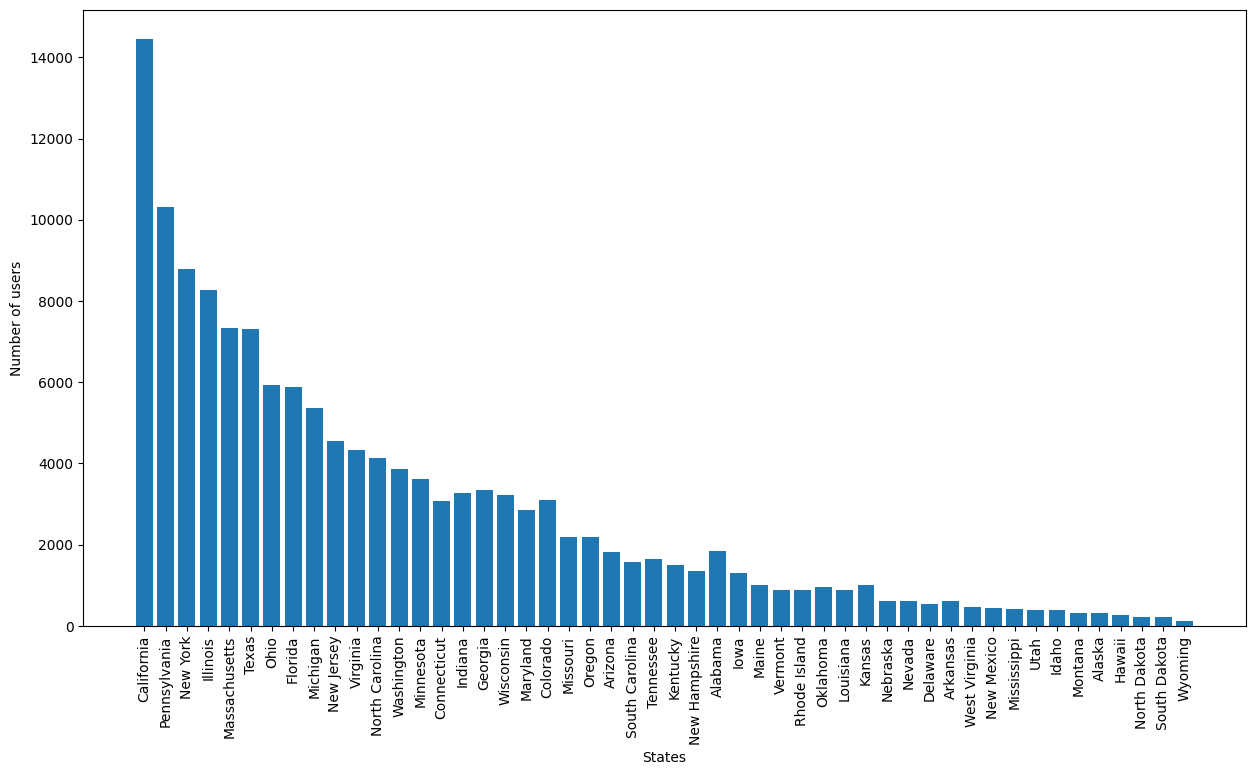

In [12]:
states_usa_ba = users_ba_usa['location'].apply(lambda x: x.split(', ')[1])
states_usa_rb = users_rb_usa['location'].apply(lambda x: x.split(', ')[1])

# print(f"USA states represented in BeerAdvocate: {len(states_usa_ba.unique())}")
# print(f"USA states represented in RateBeer: {len(states_usa_rb.unique())}")

# print(f"Number of users per state in BeerAdvocate: {states_usa_ba.value_counts()}")
# print(f"Number of users per state in RateBeer: {states_usa_rb.value_counts()}")

users_per_state_ba = states_usa_ba.value_counts().to_dict()
users_per_state_rb = states_usa_rb.value_counts().to_dict()
users_per_state_barb = {k: (users_per_state_ba[k] + users_per_state_rb[k]) for k in users_per_state_ba.keys()}

states = users_per_state_barb.keys()
users = users_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()



## Analyse distribution of US Breweries per state

In [13]:
breweries_matched = data_matched['matched_beer_data_breweries.csv']
breweries_ba = data_ba['BeerAdvocate_breweries.csv']
breweries_rb = data_rb['RateBeer_breweries.csv']
breweries_ba = breweries_ba.dropna(subset=['location'])
breweries_rb = breweries_rb.dropna(subset=['location'])

In [14]:
breweries_matched_usa = breweries_matched[breweries_matched['ba.1'].str.startswith('United States')]
breweries_ba_usa = breweries_ba[breweries_ba['location'].str.startswith('United States')]
breweries_rb_usa = breweries_rb[breweries_rb['location'].str.startswith('United States')]


print(f"Number of matched breweries in USA: {breweries_matched_usa.shape[0]}")
print(f"Number of BeerAdvocate breweries in USA: {breweries_ba_usa.shape[0]}")
print(f"Number of RateBeer breweries in USA: {breweries_rb_usa.shape[0]}")

Number of matched breweries in USA: 3956
Number of BeerAdvocate breweries in USA: 7431
Number of RateBeer breweries in USA: 6921


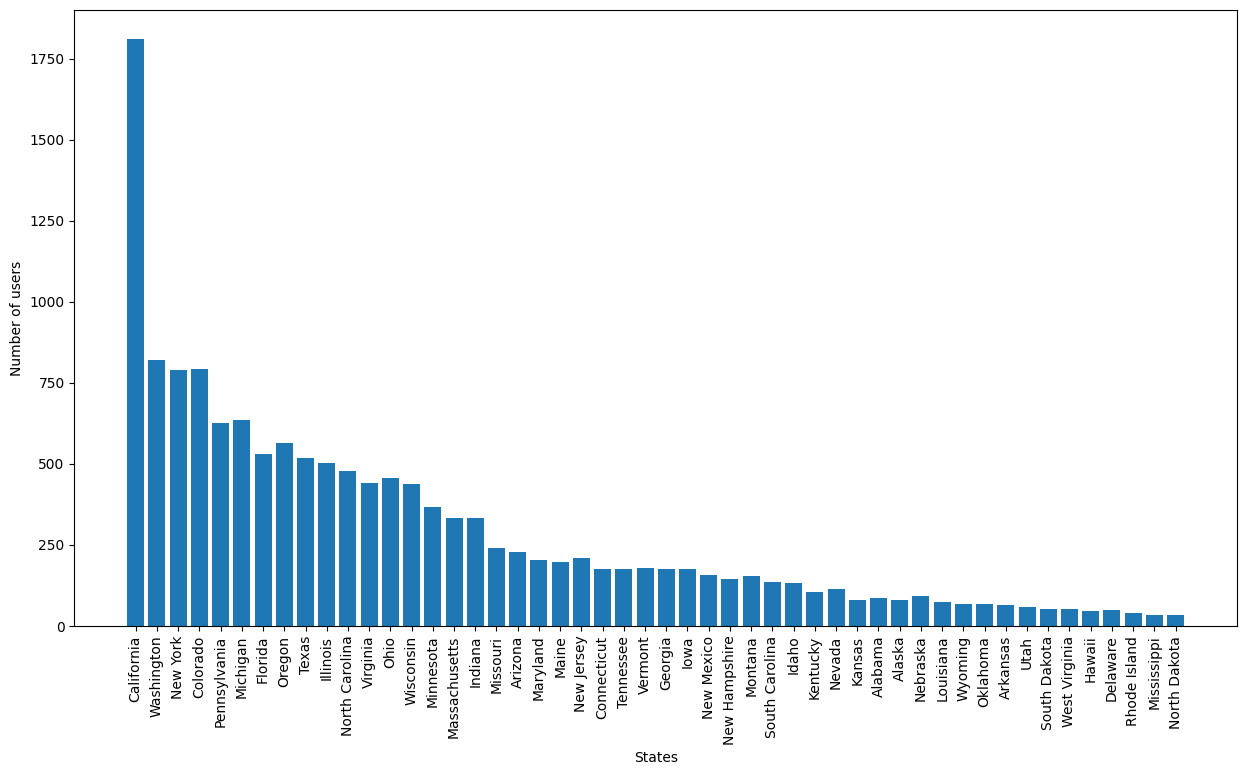

In [ ]:
breweries_name_split_ba = breweries_ba_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_ba = breweries_ba_usa[breweries_name_split_ba == 2]
breweries_filtered_ba = breweries_filtered_ba[breweries_filtered_ba['location'] != 'United States, United States']
breweries_per_states_ba = breweries_filtered_ba['location'].apply(lambda x: x.split(',')[1])

breweries_name_split_rb = breweries_rb_usa['location'].apply(lambda x: len(x.split(',')))
breweries_filtered_rb = breweries_rb_usa[breweries_name_split_rb == 2]
breweries_filtered_rb['location'] = breweries_filtered_rb['location'].mask(breweries_filtered_rb['location'] == 'United States, Washington DC', 'United States, California')
breweries_per_states_rb = breweries_filtered_rb['location'].apply(lambda x: x.split(',')[1])

# print(f"USA states with breweries represented in BeerAdvocate: {len(breweries_per_states_ba.unique())}")
# print(f"USA states with breweries represented in RateBeer: {len(breweries_per_states_rb.unique())}")

# print(f"Number of breweries per state in BeerAdvocate: {breweries_per_states_ba.value_counts()}")
# print(f"Number of breweries per state in RateBeer: {breweries_per_states_rb.value_counts()}")

breweries_per_state_ba = breweries_per_states_ba.value_counts().to_dict()
breweries_per_state_rb = breweries_per_states_rb.value_counts().to_dict()

#delete the space at the start of each key
breweries_per_state_ba = {k[1:]: v for k, v in breweries_per_state_ba.items()}
breweries_per_state_rb = {k[1:]: v for k, v in breweries_per_state_rb.items()}

breweries_per_state_barb = {k: (breweries_per_state_ba[k] + breweries_per_state_rb[k]) for k in breweries_per_state_ba.keys()}

states = breweries_per_state_barb.keys()
users = breweries_per_state_barb.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users)
ax.set_ylabel('Number of users')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()



## Analyse ratio of users per brewery in each state

{'California': 12.527448869752423, 'Pennsylvania': 26.490853658536587, 'New York': 18.305418719211822, 'Illinois': 25.81203007518797, 'Massachusetts': 37.19553072625698, 'Texas': 21.04642857142857, 'Ohio': 21.226666666666667, 'Florida': 15.501683501683502, 'Michigan': 13.12461059190031, 'New Jersey': 35.056603773584904, 'Virginia': 15.737991266375547, 'North Carolina': 13.674698795180722, 'Washington': 7.034063260340632, 'Minnesota': 15.427027027027027, 'Connecticut': 27.372549019607842, 'Indiana': 15.372093023255815, 'Georgia': 30.264367816091955, 'Wisconsin': 10.844748858447488, 'Maryland': 21.227272727272727, 'Colorado': 5.757425742574258, 'Missouri': 13.845528455284553, 'Oregon': 5.522033898305085, 'Arizona': 11.654867256637168, 'South Carolina': 18.43661971830986, 'Tennessee': 14.217391304347826, 'Kentucky': 20.74137931034483, 'New Hampshire': 15.407894736842104, 'Alabama': 22.8, 'Iowa': 11.882352941176471, 'Maine': 8.377358490566039, 'Vermont': 8.467391304347826, 'Rhode Island': 

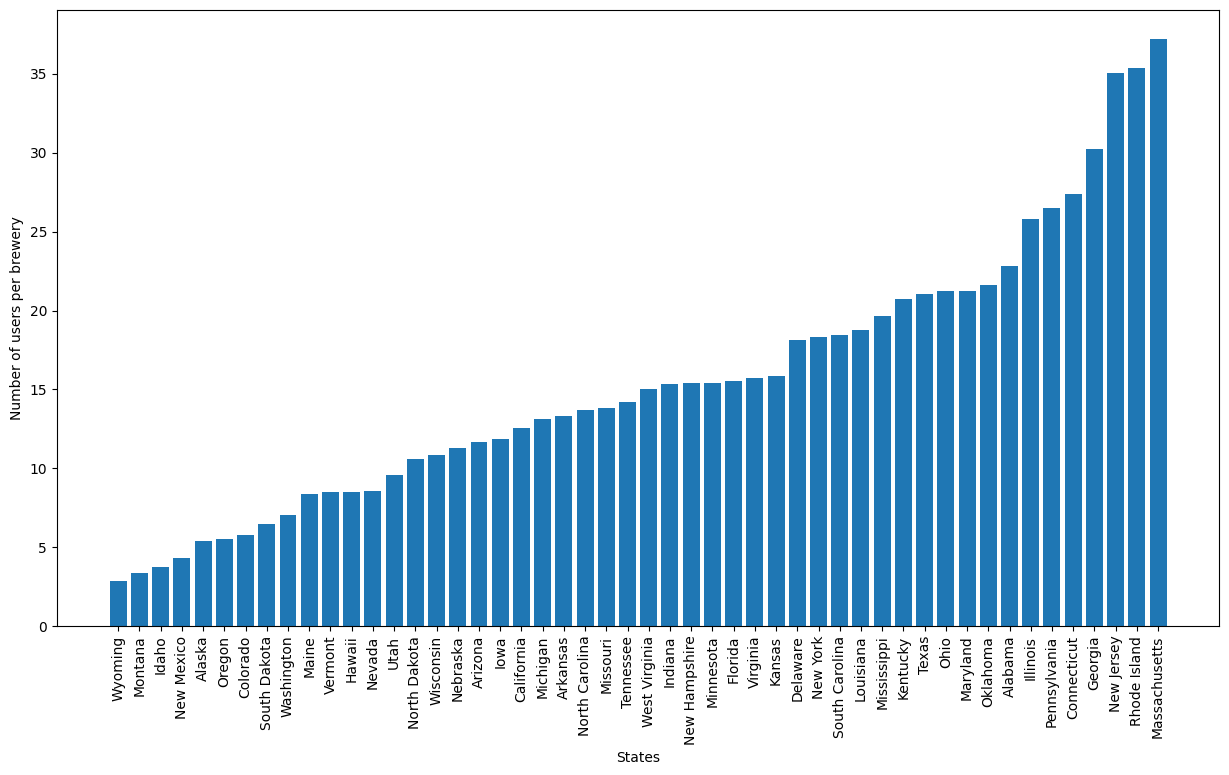

In [ ]:
#Amount of users per brewery in each state
users_per_brewery_barb = {k: (users_per_state_barb[k] / breweries_per_state_barb[k]) for k in users_per_state_ba.keys()}
print(users_per_brewery_barb)

#sort so easier to view plot
sorted_users_per_brewery_ba = dict(sorted(users_per_brewery_barb.items(), key=lambda item: item[1]))

states = sorted_users_per_brewery_ba.keys()
users_per_brewery = sorted_users_per_brewery_ba.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_brewery)
ax.set_ylabel('Number of users per brewery')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()

### Data from Census

In [ ]:
import src.data.census as census
import pandas as pd

census_path = 'data/raw/Census/'
file_name_2020 = 'DECENNIALCD1182020.H2_rural_urban_US.csv'
file_name_2010 = 'DECENNIALCD1162010.H2_rural_urban_US.csv'

urban_2020_df = census.load_urban_frac_df(census_path, file_name_2020).reset_index()
urban_2010_df = census.load_urban_frac_df(census_path, file_name_2010).reset_index()

print(urban_2020_df.head())
print(urban_2010_df.head())

            total_pop  urban_pop  rural_pop  urban_frac
state                                                  
Alabama       2288330    1325120     963210    0.579077
Alaska         326200     195718     130482    0.599994
Arizona       3082000    2741086     340914    0.889385
Arkansas      1365265     746431     618834    0.546730
California   14392140   13445407     946733    0.934219
            total_pop  urban_pop  rural_pop  urban_frac
state                                                  
Alabama       2171853    1267224     904629    0.583476
Alaska         306967     182989     123978    0.596119
Arizona       2844526    2515504     329022    0.884332
Arkansas      1316299     720584     595715    0.547432
California   13680081   12814688     865393    0.936741


## Number of users per habitant in each state
This allows us to see if we have enough users per state, compared to its population.

In [ ]:
if all(col in urban_2010_df.columns for col in ['urban_pop', 'rural_pop', 'urban_frac']):
    urban_2010_df = urban_2010_df.drop(columns=['urban_pop', 'rural_pop', 'urban_frac'])
urban_2010_dict = urban_2010_df.set_index('state').to_dict()['total_pop']

# delete keys states that are not in the 50 official
urban_2010_dict = {k: v for k, v in urban_2010_dict.items() if k in users_per_state_barb.keys()}

# number of habitants per user in each state
users_per_habitant = {k: (urban_2010_dict[k] / users_per_state_barb[k]) for k in users_per_state_barb.keys()}
print(users_per_habitant)

states = users_per_habitant.keys()
users_per_habitant = users_per_habitant.values()

fig, ax = plt.subplots(figsize=(15, 8))
ax.bar(states, users_per_habitant)
ax.set_ylabel('Number of users per habitant')
ax.set_xlabel('States')
plt.xticks(rotation=90)
plt.show()